In [1]:
from pyqpanda import *
import numpy as np

In [2]:
def draw(prog, filename=''):
    dir_path = './images/'
    if filename != '':
        draw_qprog(prog, 'pic', filename=f'{dir_path}{filename}')

## Init Quantum Environment

In [3]:
class InitQMachine:
    def __init__(self, qubitsCount, cbitsCount, machineType = QMachineType.CPU):
        self.machine = init_quantum_machine(machineType)
        
        self.qubits = self.machine.qAlloc_many(qubitsCount)
        self.cbits = self.machine.cAlloc_many(cbitsCount)
        
        print(f'Init Quantum Machine with qubits:[{qubitsCount}] / cbits:[{cbitsCount}] Successfully')
    
    def __del__(self):
        destroy_quantum_machine(self.machine)

In [4]:
ctx = InitQMachine(4, 4)

machine = ctx.machine
qubits = ctx.qubits
cbits = ctx.cbits

Init Quantum Machine with qubits:[4] / cbits:[4] Successfully


# 0. Solve using numpy

In [5]:
A = np.array([
    [1, 1],
    [2 ** 0.5 / 2, -(2 ** 0.5) / 2]
])
b = np.array([
    [1/2], [-(2 ** 0.5) / 2]
])

In [6]:
Dag = lambda matrix: matrix.conj().T

In [7]:
Dag(A)

array([[ 1.        ,  0.70710678],
       [ 1.        , -0.70710678]])

In [8]:
A_ = Dag(A) @ A # make A hermitian
b_ = Dag(A) @ b

In [9]:
normed_b = b_ / np.linalg.norm(b_)
normed_b

array([[-1.11022302e-16],
       [ 1.00000000e+00]])

In [10]:
x = np.linalg.solve(A_, b_)
x

array([[-0.25],
       [ 0.75]])

In [11]:
eigenvalue, _ = np.linalg.eig(A_)
eigenvalue

array([2., 1.])

In [12]:
np.linalg.solve(A_, normed_b)

array([[-0.25],
       [ 0.75]])

In [13]:
2 * np.pi / np.linalg.norm(A_) / np.pi

0.8944271909999159

# 1. HHL

## - 1.1 tool functions

In [14]:
Dag = lambda matrix: matrix.conj().T

In [15]:
def is_hermitian(matrix):
    return np.allclose(matrix, Dag(matrix))

In [16]:
# test is_hermitian
print(is_hermitian(A)) # false
print(is_hermitian(A_)) # true

False
True


In [17]:
def ed(m, n):
     return np.sqrt(np.sum((m - n) ** 2))

## - 1.2 HHL algorithm subroutines

In [18]:
def encode(b):
    circuit = create_empty_circuit()
    circuit << amplitude_encode(qubits[3], b)
    
    return circuit

In [19]:
draw(encode(b_), 'encode')

In [20]:
# https://arxiv.org/pdf/1110.2232.pdf

In [21]:
m = np.array(QOperator(QOracle(qubits[3], expMat(1j, A_, np.pi/2))).get_matrix())
m = m.reshape(2, 2)

ev, _ = np.linalg.eig(m)
ev.round(4)

array([-1.-0.j,  0.+1.j])

In [22]:
print(np.exp(2 * np.pi * 1j * 0.5).round(4))
print(np.exp(2 * np.pi * 1j * 0.25).round(4))

(-1+0j)
1j


In [23]:
def phase_estimation(A):
    circuit = create_empty_circuit()
    
    circuit << H(qubits[1]) << H(qubits[2]) << BARRIER(qubits[1:3])
#     t0 = 2 * np.pi
#     circuit << QOracle(qubits[3], expMat(1j, A, np.pi / 2)).control(qubits[2]) # C-U^1
#     circuit << QOracle(qubits[3], expMat(1j, A, np.pi)).control(qubits[1]) # C-U^2
    circuit << CU(-np.pi / 4, -3 * np.pi / 2, -3 * np.pi / 2, 3 * np.pi / 2, qubits[2], qubits[3])
    circuit << CU(-3 * np.pi/2, -3 * np.pi, -3 * np.pi, -2 * np.pi, qubits[1], qubits[3])
    circuit << BARRIER(qubits[1:3])
    
    # QFT_dagger
    circuit << SWAP(qubits[1], qubits[2])
    circuit << H(qubits[2])
    circuit << S(qubits[2]).dagger().control(qubits[1])
    circuit << H(qubits[1])
    circuit << SWAP(qubits[1], qubits[2])

    return circuit

In [24]:
def rotation(r):
    circuit = create_empty_circuit()
    
    circuit << RY(qubits[0], 2*np.pi/(2**r)).control(qubits[1])
    circuit << RY(qubits[0], np.pi/(2**r)).control(qubits[2])
    
    return circuit

In [25]:
def uncompute(A):
    circuit = create_empty_circuit()
    
    # QFT_dagger
    circuit << SWAP(qubits[1], qubits[2])
    circuit << H(qubits[1])
    circuit << S(qubits[2]).control(qubits[1])
    circuit << H(qubits[2])
    circuit << SWAP(qubits[1], qubits[2])

#     t0 = 2 * np.pi
#     circuit << QOracle(qubits[3], expMat(-1j, A, t0 / 2)).control(qubits[1])
#     circuit << QOracle(qubits[3], expMat(-1j, A, t0 / 4)).control(qubits[2])
    circuit << CU(-3 * np.pi/2, -3 * np.pi, -3 * np.pi, -2 * np.pi, qubits[1], qubits[3])
    circuit << CU(np.pi/4, -3*np.pi/2, -np.pi/2, -np.pi/2, qubits[2], qubits[3])
    circuit << H(qubits[1]) << H(qubits[2])
    
    return circuit

## - 1.3 full HHL algorithm 

In [47]:
def HHL(A, b, r, flag=False):
    prog = create_empty_qprog()
    
    # Step 0. check input
    if not is_hermitian(A):
        b = (Dag(A) @ b).round(4)
        A = (Dag(A) @ A).round(4) # make A hermitian
    
    normed_b = (b / np.linalg.norm(b)).round(4)
    
    # Step 1. state preparation
    prog << encode(normed_b)
    
    # Step 2. phase estimation
    prog << phase_estimation(A)
    
    # Step 3. rotation
    prog << rotation(r)
    
    # Step 4. uncompute
    prog << uncompute(A)
    
    # Step 5. measure ancilla qubit
    prog << Measure(qubits[0], cbits[0])
    if flag:
        results = [0, 0]
        for i in range(10000):
            result = prob_run_list(prog, qubits[0], -1)
            results[0] += result[0]
            results[1] += result[1]

        results[0] /= 10000
        results[1] /= 10000
        
        return results
    
    result = directly_run(prog)
    
    if not result['c0']:
        return HHL(A, b, r)
    
    # Step 6. get results
    prog << Measure(qubits[3], cbits[3])
    
    qstate = get_qstate()
    normed_x = np.real(np.array([qstate[1], qstate[9]])) # 0001 1001
        
    # Step 7. recover x
    N = len(normed_b)
    ratio = 0.0
    for i in range(N):
        if not abs(normed_b[i]) < 1e-8:
            ratio = normed_b[i][0] / np.sum([ normed_x[j] * A[i][j] for j in range(N) ])
            break
    
    # normed_x = x / ||x|| => x = normed_x * ||x||
    x_ = (normed_x * ratio)
    distance = ed(x_, x.flatten())
    
    return distance, x_

In [75]:
HHL(A, b, 5)

(0.00047642467882998396, array([-0.24954802,  0.74984934]))

In [49]:
HHL(A, b, 8, True)

[0.9999000000000002, 0.00010000000000141353]

In [50]:
r = [1, 2, 3, 4, 5, 6, 7, 8]

In [53]:
p = [ HHL(A, b, i, True)[1] for i in r]

In [55]:
distances = [ HHL(A, b, i)[0] for i in r ]

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline

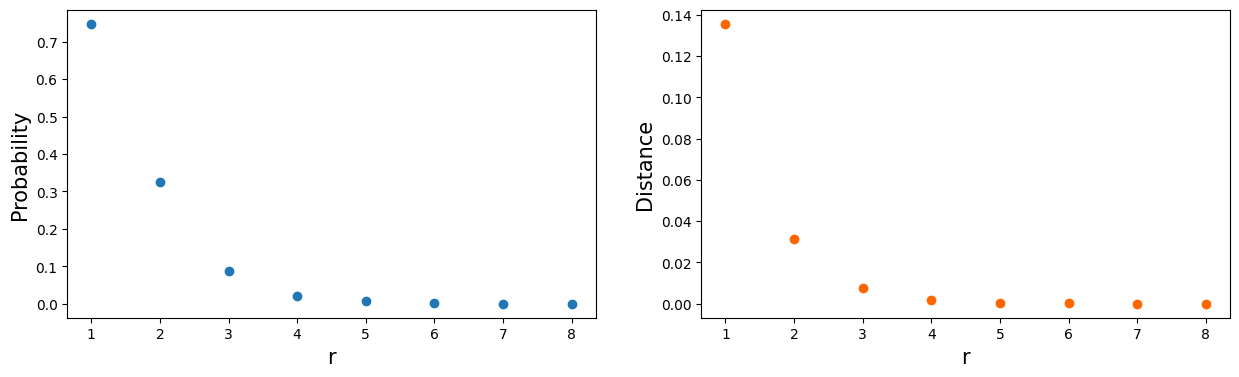

In [74]:
plt.figure(figsize=(15, 4))
plt.subplot(1,2,1)
plt.scatter(r, p)
plt.xlabel("r", fontsize=15)
plt.ylabel("Probability", fontsize=15)

plt.subplot(1,2,2)
plt.scatter(r, distances, color="#FF6600")
plt.xlabel("r", fontsize=15)
plt.ylabel("Distance", fontsize=15)

plt.show()